In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../../src')

In [4]:
import scanpy as sc

In [5]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')
sys.path.append('/Users/koush/Projects/Banksy_py')
import celloracle as co
from spaceoracle.plotting.cartography import xy_from_adata

In [6]:
adata = sc.read_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')
adata

AnnData object with n_obs × n_vars = 4194 × 3000
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw'
    obsp: 'connectivities', 'distances'

In [7]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/Volumes/SSD/training_data/human_tonsil_proteomics_colinks.pkl',
    annot='cell_type_int'
)

In [8]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata, 
    target_gene='PAX5', 
    cluster_annot='cell_type_int',
    radius=350, 
    contact_distance=50,
    grn=co_grn,
)

AssertionError: target_gene must be in adata.var_names

In [47]:
estimator.fit(num_epochs=100, learning_rate=5e-3, 
    score_threshold=0.2, l1_reg=1e-9, estimator='lasso')

Fitting Cd74 with 241 modulators
	26 Transcription Factors
	172 Ligand-Receptor Pairs
	43 TranscriptionFactor-Ligand Pairs
0: 0.8295 | 0.8126
1: 0.6813 | 0.6588
2: 0.5725 | 0.5384
3: 0.7673 | 0.7474
4: 0.9218 | 0.9169
5: 0.8953 | 0.8845
6: 0.9228 | 0.9189


In [48]:
betadata = estimator.betadata

In [49]:
xy = xy_from_adata(adata)

In [51]:
betadata[[i for i in betadata.columns if 'Ccl5' in i]].join(adata.obs.cell_type).groupby(
    'cell_type'
).mean()

,beta_Ccl5$Ccr4
cell_type,
B,0.000000
CD8+ T,0.000041
DC,0.000000
Resting T,-0.002576
Tfh,-0.012162
Th2,-0.002162
Treg,-0.005969


In [52]:
betadata = betadata.loc[:, (betadata != 0).any(axis=0)]

In [53]:
adata.obs.drop(columns=['celltype_label_tangram']).drop_duplicates().sort_values(
    'cell_type_int')

,cell_type,cell_type_int
TCAAGGAATGTGCT,B,0
GGAAAACCCCGAGG,CD8+ T,1
TGCGGGGCGCATGT,DC,2
ACGTTTTTGAAATG,Resting T,3
GGTTTGACGGCCGT,Tfh,4
CTTTACTCAGTCTG,Th2,5
TTTTTTACATCATC,Treg,6


In [54]:
pd.DataFrame({f'cluster_{i}': estimator.models[i].anchors.cpu().numpy()[1:] 
    for i in range(len(estimator.models))}, index=estimator.modulators).loc[
        [i.replace('beta_', '') for i in betadata.columns if '$' in i]].head(50)

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
Tgfb1$Tgfbr1,3.526777e-05,-0.000224,3.395620e-08,-6.091489e-04,2.302797e-05,-1.931496e-05,3.691787e-04
Tgfb1$Tgfbr2,7.278265e-03,-0.000518,-2.303497e-04,3.031170e-04,4.712772e-04,6.682815e-04,2.976023e-05
Gdf15$Tgfbr2,8.276540e-05,-0.000000,-0.000000e+00,0.000000e+00,-1.340052e-08,0.000000e+00,-2.658765e-07
Igf1$Igf1r,0.000000e+00,-0.000156,-2.252439e-05,2.009995e-07,2.058212e-06,-4.906944e-05,-5.143417e-05
Igf1$Itgav,1.739404e-04,-0.000067,9.332891e-05,-2.202637e-06,1.220159e-07,1.319636e-05,-6.352886e-07
Igf1$Itgb3,2.634117e-05,-0.000174,-0.000000e+00,-7.497944e-07,-1.582364e-04,-7.052710e-05,-5.116786e-06
Igf1$Itga6,0.000000e+00,-0.000077,-0.000000e+00,2.691611e-05,-3.443433e-07,-1.720261e-04,-1.949172e-04
Ccl8$Ccr2,4.291938e-04,-0.000444,6.674179e-04,3.516348e-04,3.122370e-04,9.522997e-04,1.850238e-03
Ccl6$Ccr2,-1.548619e-08,-0.000046,1.907709e-06,1.270887e-06,5.299485e-08,2.935000e-05,2.354384e-04
Ccl2$Ccr2,-0.000000e+00,-0.000096,5.476036e-07,8.041664e-08,-2.565800e-09,9.687893e-07,2.074527e-04


In [55]:
betadata = betadata.join(adata.obs.cell_type_int)

In [56]:
betadata = betadata.join(xy)

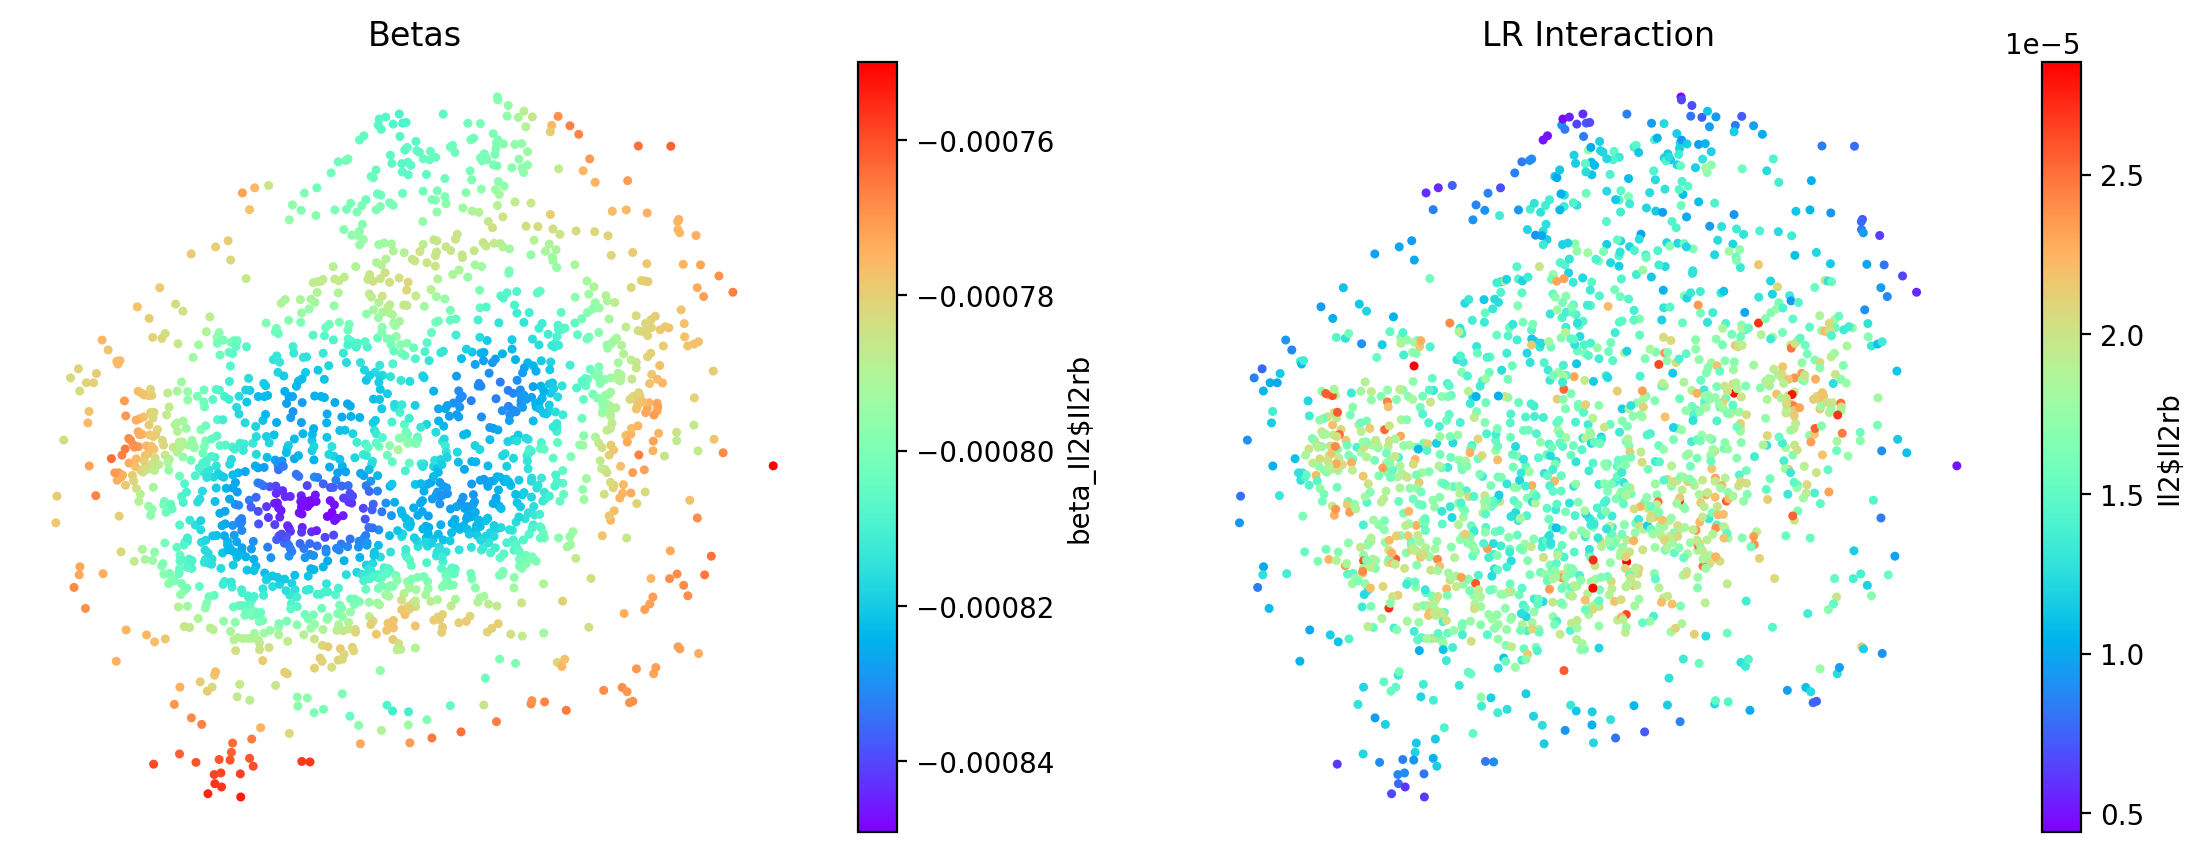

In [64]:
%matplotlib inline
f, ax = plt.subplots(1, 2, figsize=(14, 5))
cmap = 'rainbow'
beta = 'Il2$Il2rb'
data = betadata[betadata.cell_type_int.isin([6])][
    ['x', 'y', f'beta_{beta}']].join(estimator.train_df[[beta]])


scatter1 = ax[0].scatter(
    data['x'],
    data['y'], 
    c=data[f'beta_{beta}'],
    s=5,
    cmap=cmap
)
f.colorbar(scatter1, ax=ax[0], label=f'beta_{beta}')

scatter2 = ax[1].scatter(
    data['x'],
    data['y'],
    c=data[beta],
    s=5, 
    cmap=cmap
)
f.colorbar(scatter2, ax=ax[1], label=beta)
# Remove ticks and spines
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    for spine in ['top', 'right', 'left', 'bottom']:
        a.spines[spine].set_visible(False)
        
ax[0].set_title('Betas')
ax[1].set_title('LR Interaction')
plt.show()

In [13]:
betadata = estimator.betadata

In [15]:
beta_cols = [i for i in betadata.columns if 'beta' in i]

In [42]:
betadata[beta_cols].min().sort_values(ascending=False).to_frame()

NameError: name 'betadata' is not defined

<Axes: ylabel='Frequency'>

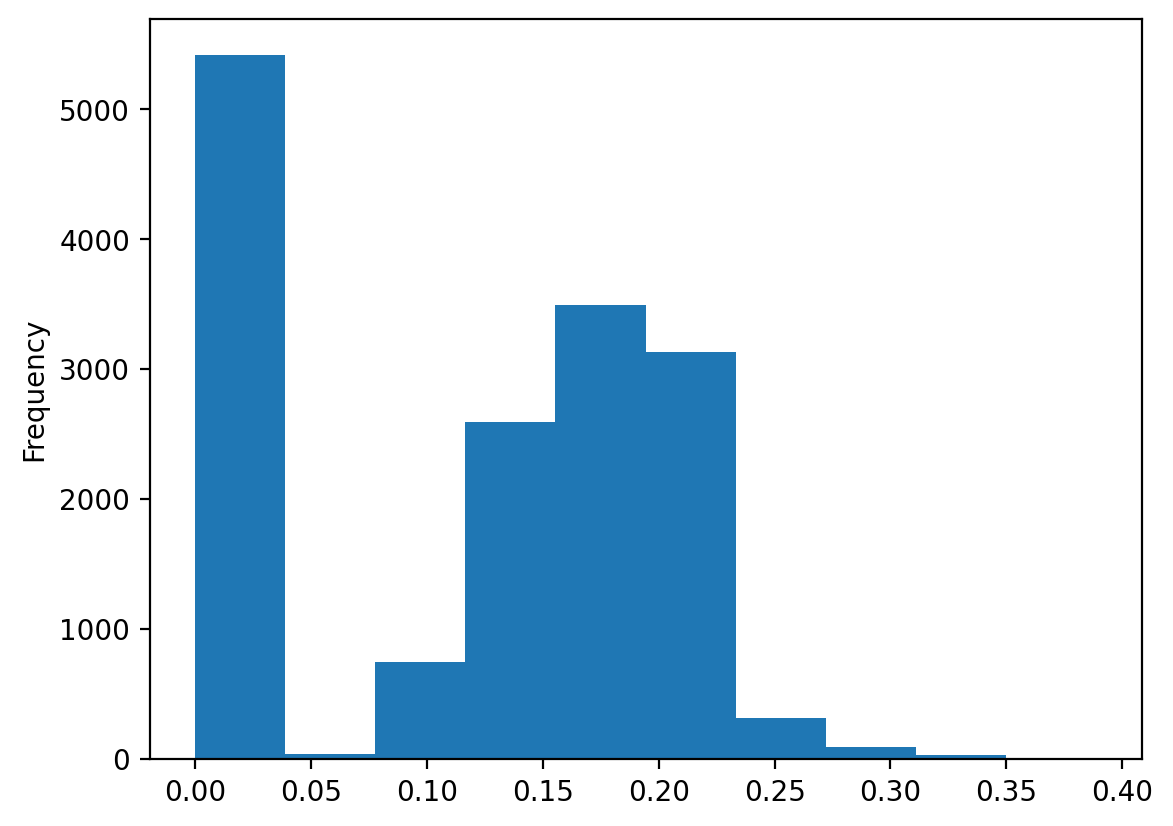

In [24]:
betadata['beta_Spp1$Itgb5'].plot.hist()

In [50]:
_ = estimator.init_data()

In [51]:
estimator.train_df

,Lmo4,Atf3,Bach2,Bcl6,Bclaf1,E2f5,Ebf1,Egr1,Egr2,Elf1,...,Tgfb1#Tbx21,Il10#Tbx21,Il4#Tbx21,Angptl4#Tbx21,Il18#Tbx21,Cxcl12#Zbtb4,Enho#Zbtb4,Osm#Zbtb4,Gas6#Zbtb4,Retn#Zbtb4
AAAAAAAGCCAACA,0.012445,0.000257,0.009548,0.015360,0.036482,0.000631,0.044011,0.012597,0.012576,0.033060,...,0.004000,0.000015,0.001142,0.000525,0.000616,0.017181,0.001493,0.008068,0.001787,0.000141
AAAAAACGGTAGAT,0.022555,0.002632,0.014507,0.023408,0.044147,0.000468,0.033825,0.014989,0.005486,0.067444,...,0.004929,0.000123,0.001154,0.002104,0.002227,0.006676,0.000180,0.001166,0.007667,0.000884
AAAAAATCCGGCGA,0.016663,0.000745,0.020385,0.013550,0.081072,0.001196,0.011923,0.053883,0.009464,0.065867,...,0.001386,0.000023,0.000701,0.000535,0.000264,0.001443,0.000060,0.001526,0.000422,0.000052
AAAAACCGTCAGAC,0.024725,0.000452,0.027911,0.018477,0.067621,0.013032,0.057225,0.011174,0.005321,0.061781,...,0.001972,0.000010,0.000548,0.000332,0.000410,0.002648,0.000288,0.001380,0.000734,0.000041
AAAAACGCTCCGAC,0.032663,0.000377,0.026700,0.039854,0.049508,0.001464,0.043104,0.020314,0.007169,0.044657,...,0.002471,0.000019,0.000944,0.000425,0.000484,0.003725,0.000572,0.002562,0.000924,0.000054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGTACGATT,0.022742,0.000290,0.022258,0.023101,0.051606,0.001278,0.040656,0.017397,0.007029,0.074133,...,0.001592,0.000021,0.000620,0.000678,0.000545,0.003373,0.000209,0.001531,0.000786,0.000108
TTTTTTTATGGTAC,0.026378,0.000668,0.012909,0.013981,0.045196,0.000855,0.015796,0.018489,0.010479,0.047549,...,0.001542,0.000052,0.000774,0.000805,0.001253,0.003944,0.000396,0.001771,0.003053,0.000116
TTTTTTTGTCGCCT,0.018406,0.000564,0.019626,0.013731,0.058910,0.000792,0.031595,0.021745,0.011246,0.041488,...,0.000510,0.000005,0.000296,0.000117,0.000276,0.001569,0.000155,0.001161,0.000521,0.000108
TTTTTTTTATTATA,0.027357,0.000236,0.036435,0.015227,0.045797,0.002581,0.036281,0.026586,0.010420,0.048596,...,0.003838,0.000047,0.001582,0.001038,0.001280,0.006916,0.000420,0.002444,0.001151,0.000213


In [33]:
from spaceoracle.models.pixel_attention import CellularNicheNetwork
import torch

In [53]:
y_pred = CellularNicheNetwork.predict_y(
    inputs_x=torch.tensor(estimator.train_df.drop(columns=['Lmo4']).values).float(),
    betas=torch.tensor(df[[i for i in df.columns if 'beta' in i]].values).float()
).detach().cpu().numpy()

In [42]:
%matplotlib inline

In [45]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr


In [54]:
r2_score(estimator.train_df['Lmo4'], y_pred)

0.20468419197598042

In [55]:
spearmanr(estimator.train_df['Lmo4'], y_pred)

SignificanceResult(statistic=0.423324048058558, pvalue=0.0)

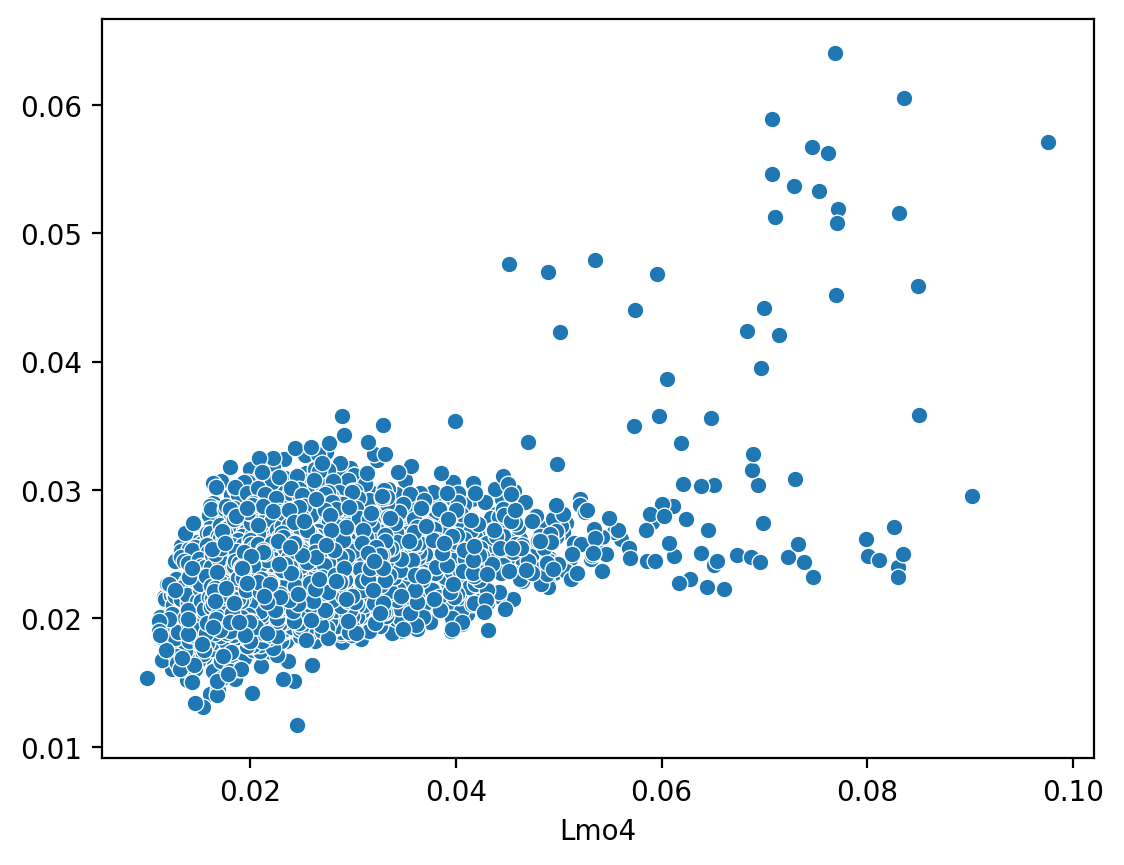

In [57]:
sns.scatterplot(y=y_pred, x=estimator.train_df['Lmo4'])
plt.show()

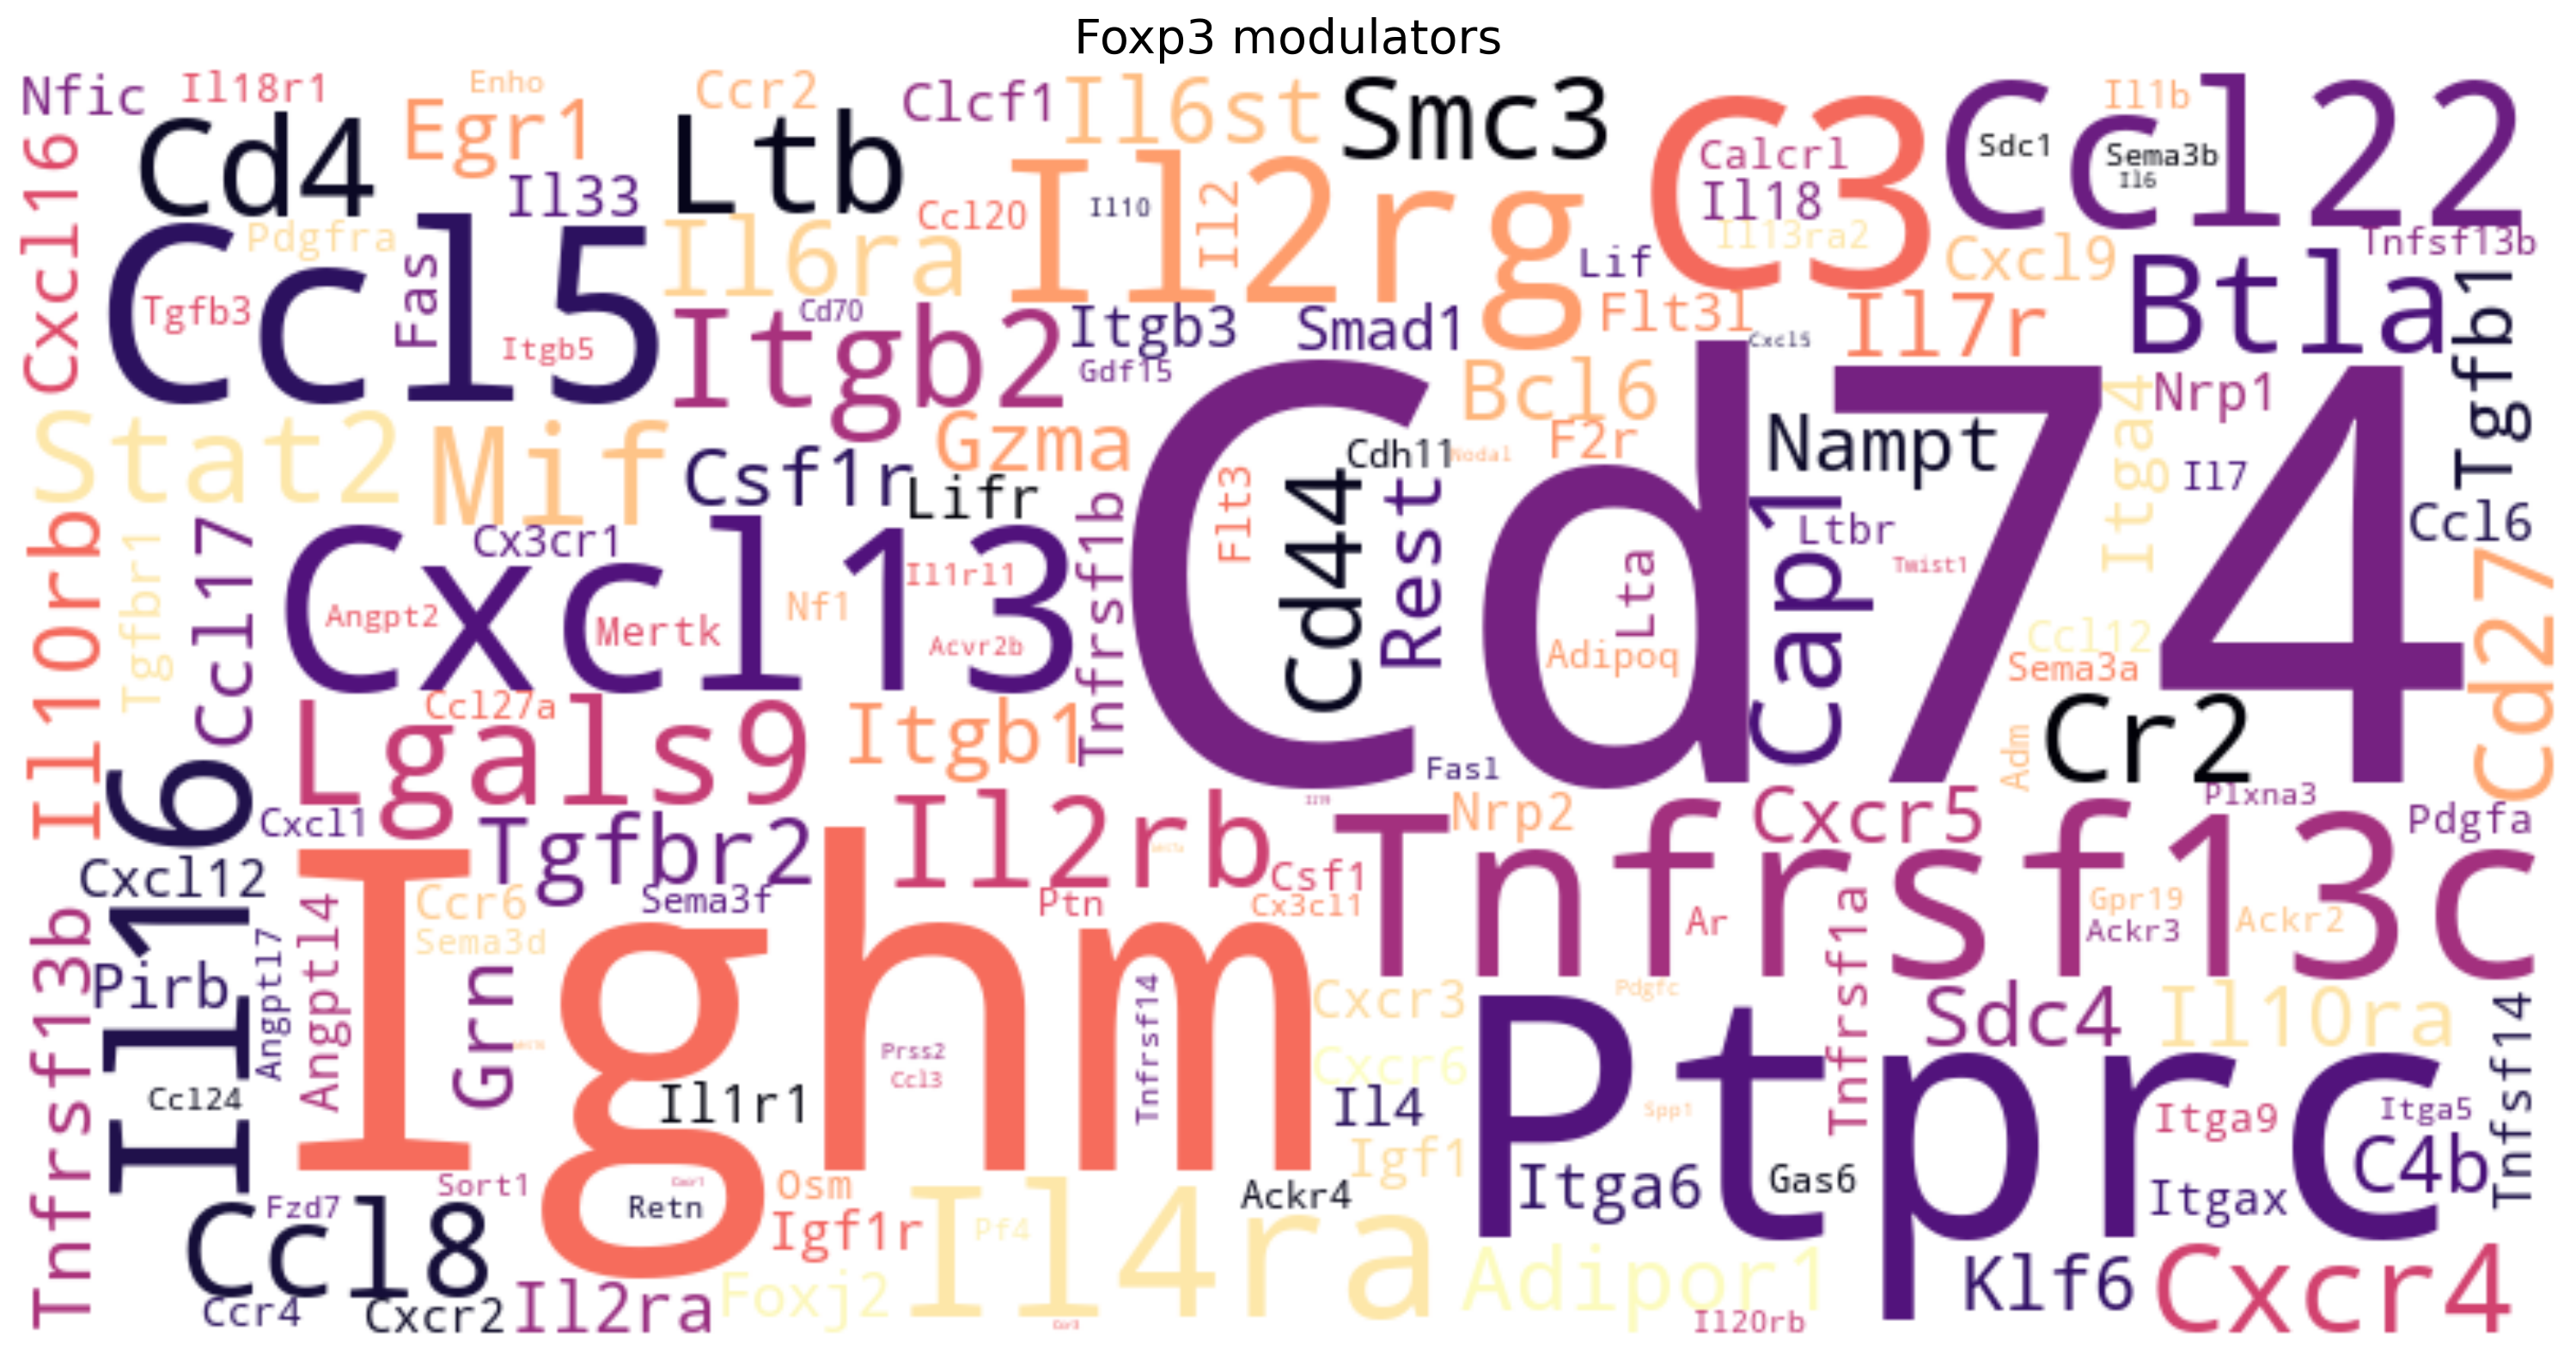

In [19]:
%matplotlib inline
estimator.plot_modulators(cmap='magma')

In [20]:
estimator.fit(num_epochs=1, learning_rate=5e-3)

Fitting Foxp3 with 169 modulators
	12 Transcription Factors
	131 Ligand-Receptor Pairs
	26 TranscriptionFactor-Ligand Pairs
0: -0.0742 | 0.2958
1: -2.0188 | 0.3736
2: -1.3595 | 0.4958
3: -3.9662 | 0.5557
4: -3.0252 | 0.2935
5: -2.1991 | 0.2116
6: -1.5058 | 0.1995


In [21]:
betadata = estimator.betadata

In [25]:
betadata[[i for i in betadata.columns if 'beta' in i]]

,beta0,beta_Ar,beta_Bcl6,beta_Egr1,beta_Foxj2,beta_Klf6,beta_Nf1,beta_Nfic,beta_Rest,beta_Smad1,...,beta_Enho#Rest,beta_Il6#Smad1,beta_Il18#Smad1,beta_Tnfsf13b#Smad1,beta_Ccl12#Smad1,beta_Clcf1#Smc3,beta_Clcf1#Stat2,beta_Il10#Stat2,beta_Tgfb1#Twist1,beta_Igf1#Twist1
AAAAAAAGCCAACA,0.001539,0.019648,0.000402,0.019150,-0.012115,0.006353,0.003878,0.000923,0.001869,0.014601,...,0.000143,2.430738e-04,-0.009802,0.000042,-0.019659,-0.011353,-0.015345,0.002120,-0.000131,0.001108
AAAAAACGGTAGAT,0.001353,0.016467,0.000431,0.015818,-0.009832,0.004881,0.003066,0.000843,0.001600,0.011310,...,0.000377,1.481917e-04,-0.011096,0.000011,-0.016599,-0.010842,-0.014171,0.002025,-0.000121,0.000816
AAAAAATCCGGCGA,0.004020,0.000075,0.001146,-0.000031,0.001869,0.006198,0.000021,0.000191,0.000708,0.000111,...,0.000006,2.008704e-07,-0.000027,-0.000144,-0.000016,-0.000003,-0.000288,-0.000175,0.000004,0.000009
AAAAACCGTCAGAC,0.001391,0.017863,0.000405,0.016829,-0.010485,0.004987,0.003415,0.000857,0.001599,0.012331,...,0.000286,1.783186e-04,-0.009596,0.000075,-0.017184,-0.010688,-0.014507,0.002155,-0.000120,0.001080
AAAAACGCTCCGAC,0.001424,0.017926,0.000432,0.017018,-0.010651,0.005466,0.003537,0.000882,0.001692,0.012897,...,0.000169,1.872206e-04,-0.010404,0.000070,-0.017605,-0.010844,-0.014799,0.001758,-0.000121,0.000944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGTACGATT,0.001543,0.020121,0.000408,0.019179,-0.011959,0.006119,0.003876,0.000916,0.001806,0.014299,...,0.000317,2.323545e-04,-0.009491,0.000082,-0.019721,-0.011425,-0.015702,0.002414,-0.000133,0.001230
TTTTTTTATGGTAC,0.001504,0.019756,0.000408,0.018725,-0.011744,0.006033,0.003742,0.000908,0.001739,0.013936,...,0.000351,2.187422e-04,-0.009169,0.000088,-0.019253,-0.011542,-0.015570,0.002643,-0.000131,0.001230
TTTTTTTGTCGCCT,-0.000002,-0.001729,0.019045,0.000142,0.008218,0.010590,0.014151,0.018759,0.004353,0.003862,...,0.000108,-6.426514e-05,0.004169,-0.000060,0.002024,0.004902,0.005362,0.000038,0.000018,-0.000514
TTTTTTTTATTATA,0.001393,0.018052,0.000386,0.017076,-0.010668,0.004924,0.003368,0.000854,0.001570,0.012421,...,0.000317,1.848855e-04,-0.008955,0.000079,-0.017349,-0.010669,-0.014443,0.002450,-0.000121,0.001189


In [23]:
estimator.train_df

,Foxp3,Ar,Bcl6,Egr1,Foxj2,Klf6,Nf1,Nfic,Rest,Smad1,...,Enho#Rest,Il6#Smad1,Il18#Smad1,Tnfsf13b#Smad1,Ccl12#Smad1,Clcf1#Smc3,Clcf1#Stat2,Il10#Stat2,Tgfb1#Twist1,Igf1#Twist1
AAAAAAAGCCAACA,0.001721,0.011551,0.015360,0.012597,0.004367,0.009738,0.001814,0.002964,0.013205,0.004924,...,0.000394,0.000026,0.000843,0.000213,0.000693,0.010076,0.015759,0.000174,0.000003,7.137703e-07
AAAAAACGGTAGAT,0.001082,0.002033,0.023408,0.014989,0.007301,0.018051,0.001688,0.013184,0.018932,0.017047,...,0.000240,0.000026,0.006792,0.001001,0.010025,0.006315,0.007942,0.000752,0.000186,2.654871e-04
AAAAAATCCGGCGA,0.010355,0.005054,0.013550,0.053883,0.006111,0.018494,0.001750,0.002967,0.013344,0.007006,...,0.000065,0.000051,0.000583,0.000285,0.000456,0.003110,0.002781,0.000160,0.000046,1.811331e-05
AAAAACCGTCAGAC,0.000704,0.000408,0.018477,0.011174,0.010579,0.012860,0.001365,0.005086,0.020294,0.008220,...,0.000677,0.000032,0.002404,0.000570,0.001601,0.030650,0.020574,0.000284,0.000373,8.795536e-05
AAAAACGCTCCGAC,0.002275,0.001739,0.039854,0.020314,0.007485,0.014620,0.005011,0.004337,0.021374,0.008240,...,0.000984,0.000152,0.001819,0.000568,0.001715,0.010199,0.011053,0.000268,0.000281,7.164873e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGTACGATT,0.001968,0.000967,0.023101,0.017397,0.007044,0.010528,0.001228,0.008125,0.030525,0.008073,...,0.000563,0.000041,0.001715,0.000450,0.001079,0.010690,0.009090,0.000270,0.000012,5.273149e-06
TTTTTTTATGGTAC,0.002402,0.002417,0.013981,0.018489,0.009335,0.010510,0.000978,0.020891,0.011252,0.020038,...,0.000341,0.000082,0.007453,0.001417,0.004366,0.003110,0.010087,0.000820,0.000059,6.803674e-05
TTTTTTTGTCGCCT,0.001763,0.005670,0.013731,0.021745,0.005943,0.011560,0.000364,0.004109,0.009960,0.010341,...,0.000100,0.000081,0.001561,0.000176,0.000734,0.003384,0.003223,0.000076,0.000054,2.540678e-05
TTTTTTTTATTATA,0.001338,0.000485,0.015227,0.026586,0.009039,0.015632,0.004853,0.006010,0.018603,0.006688,...,0.000434,0.000317,0.001993,0.000571,0.001192,0.010747,0.011533,0.000335,0.000020,7.140322e-06


In [50]:
adata.to_df(layer='normalized_count')[adata.obs.cell_type == 'B-cell'][
    np.unique(estimator.receptors)].mean().sort_values(ascending=False)

Cd74         0.878205
Ighm         0.466637
Ptprc        0.175377
Tnfrsf13c    0.127490
Il21r        0.089831
               ...   
Fzd10        0.000000
Chrna5       0.000000
Sstr3        0.000000
Chrng        0.000000
Chrna1       0.000000
Length: 210, dtype: float32

In [82]:
adata.to_df(layer='normalized_count').join(adata.obs.cell_type).groupby('cell_type').mean()[
    np.unique(estimator.receptors)].T.loc[['Il2ra', 'Cxcr4', 'Cxcr5', 'Il21r']]

cell_type,B-cell,Cd8 T-cell,Th2,Resting T-cell,Tfh,Treg,NK
Il2ra,0.004083,0.012403,0.033336,0.005862,0.013932,0.046951,0.020475
Cxcr4,0.041578,0.026619,0.021212,0.012957,0.031951,0.023913,0.031377
Cxcr5,0.021891,0.006752,0.006757,0.000398,0.008703,0.003792,0.008154
Il21r,0.089831,0.095633,0.083565,0.084297,0.088875,0.068960,0.075117


In [ ]:
estimator.train_df

In [79]:
pd.DataFrame(
    estimator.models[0].anchors[1:].cpu().numpy(), 
    index=estimator.train_df.columns[1:]
).sort_values(by=0, ascending=False)

,0
Il17a$Il17ra,2.132991
Il13$Il4ra,1.992557
Nr1h4,1.477392
Cd40lg$Itgb2,1.421578
Tnfsf13b$Tnfrsf13b,1.372255
...,...
Il18$Il18r1,-1.331378
Il4$Il13ra2,-1.410662
Nampt$Itga5,-1.502363
Ccl6$Ccr2,-1.684606


In [59]:
betadata = estimator.betadata

In [60]:
beta_cols = [i for i in betadata.columns if 'beta_' in i]

In [61]:
betadata[beta_cols].mean().sort_values(ascending=False)

beta_PATZ1           0.335779
beta_FOXP1           0.286179
beta_THAP1           0.271335
beta_TCF7L2          0.186623
beta_GLIS3           0.172774
                       ...   
beta_BHLHE40        -0.067158
beta_CSF1$CSF1R     -0.070296
beta_CLCF1$LIFR     -0.083664
beta_ZNF263         -0.105564
beta_CXCL12$ACKR3   -0.141769
Length: 163, dtype: float32

In [39]:
from spaceoracle.prophets import Prophet
import anndata as ad
import pandas as pd
import matplotlib

In [70]:
betadata.to_parquet(f'/tmp/models/{estimator.target_gene}_betadata.parquet')

In [43]:
!mkdir /tmp/models

In [90]:
fs = filesystem(
    'sftp', 
    host='htc.crc.pitt.edu', 
    username='kor11', 
    password=get_exports_from_zshrc()['HTCRC_PASSWORD']
)

with fs.open('/ix/djishnu/shared/djishnu_kor11/super_filtered_runs/mLDN3-1_v4/Pax5_betadata.parquet') as f:
    df_ssh = pd.read_parquet(f)

In [91]:
df_ssh.to_parquet(f'/tmp/models/Pax5_betadata.parquet')

In [155]:
import glob
from tqdm import tqdm

In [156]:
all_pairs = set()
paths = list(glob.glob('/Volumes/SSD/mLDN3-1_v4/*_betadata.parquet'))
for x in tqdm(paths):
    for pairs in [i for i in pd.read_parquet(x).columns if '#' in i]:
        all_pairs.add(pairs)



100%|██████████| 2859/2859 [01:12<00:00, 39.48it/s]


In [158]:
all_pairs = list(all_pairs)

In [160]:
all_pairs

['beta_Gas6#Prox1',
 'beta_Il1b#Nfe2l2',
 'beta_Tgfb1#Tbx3',
 'beta_Gas6#Creb3l1',
 'beta_Il18#Rel',
 'beta_Il4#Stat2',
 'beta_Ptn#Hesx1',
 'beta_Tgfb1#Osr1',
 'beta_Il4#Erg',
 'beta_Adm#Npas1',
 'beta_Clcf1#Hoxa2',
 'beta_Clcf1#Mef2c',
 'beta_Il10#Klf4',
 'beta_Tgfb1#Fli1',
 'beta_Lta#Dmrt2',
 'beta_Ltb#Gli3',
 'beta_Nodal#Zfhx3',
 'beta_Retn#Nfe2l2',
 'beta_Tnfsf13b#Hesx1',
 'beta_Osm#Zfhx3',
 'beta_Osm#Dmrt2',
 'beta_Il10#Foxp3',
 'beta_Osm#Runx1',
 'beta_Tnfsf13b#Id1',
 'beta_Il2#Egr2',
 'beta_Retn#Sox11',
 'beta_Cxcl12#Zbtb4',
 'beta_Enho#Sox11',
 'beta_Nodal#Elk3',
 'beta_Tgfb1#Hoxd10',
 'beta_Tgfb1#Ar',
 'beta_Enho#Nr1d2',
 'beta_Cx3cl1#Hesx1',
 'beta_Il18#Relb',
 'beta_Il10#Erg',
 'beta_Nampt#Ezh2',
 'beta_Osm#Sox11',
 'beta_Il18#Creb3l2',
 'beta_Prss2#Nfic',
 'beta_Il1b#Atf3',
 'beta_Il4#Tbx21',
 'beta_Osm#Ebf1',
 'beta_Angptl4#Fosb',
 'beta_Cxcl12#Snai2',
 'beta_Tgfb3#Id2',
 'beta_Clcf1#Hltf',
 'beta_Il7#Klf4',
 'beta_Osm#Ezh2',
 'beta_Clcf1#Erg',
 'beta_Ccl12#Cebpa',
 'beta_

In [171]:
[i.split('#')[1] for i in all_pairs if 'Il4' in i]


['Stat2',
 'Erg',
 'Tbx21',
 'Runx1',
 'Egr2',
 'Nfic',
 'Esrra',
 'Itgb2',
 'Nfe2l2',
 'Prdm1',
 'Cebpa',
 'Twist1',
 'Fli1',
 'Hoxa2',
 'Creb3l2',
 'Tcf4',
 'Mafb']

In [122]:
nichenet_lt = pd.read_parquet('/Users/koush/Projects/SpaceOracle/data/ligand_target_mouse.parquet')

In [128]:
nichenet_lt = nichenet_lt.loc[np.intersect1d(nichenet_lt.index, adata.var_names)][np.intersect1d(nichenet_lt.columns, adata.var_names)]

In [168]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata=adata,
    target_gene='Il4',
    layer='imputed_count',
    cluster_annot='cell_type_int', 
    grn=co_grn,
    radius=100
)

In [169]:
estimator.regulators

['Ar',
 'Atf3',
 'Bclaf1',
 'Creb3',
 'E2f5',
 'Ebf1',
 'Egr1',
 'Elf1',
 'Fos',
 'Fosb',
 'Foxp3',
 'Hdac2',
 'Irf6',
 'Irf9',
 'Jdp2',
 'Jun',
 'Klf12',
 'Klf4',
 'Klf6',
 'Mef2c',
 'Myef2',
 'Nr1h4',
 'Pax5',
 'Pbx3',
 'Prox1',
 'Rest',
 'Rorc',
 'Rreb1',
 'Rxra',
 'Smad1',
 'Smc3',
 'Snai2',
 'Spi1']

In [137]:
#ligands
nichenet_lt['Ccl5']

Aaas       0.004466
Aamdc      0.002916
Aatk       0.002758
Abca7      0.002692
Abcc1      0.004284
             ...   
Zmym5      0.002245
Zscan30    0.001756
Zswim5     0.001824
Zwilch     0.002837
Zzef1      0.003322
Name: Ccl5, Length: 2936, dtype: float32

In [141]:
nichenet_lt['Ccl5'].sort_values(ascending=False)[:10]

Il6       0.072890
Ccl12     0.069603
Il1b      0.069238
Cd44      0.064493
Il4       0.063786
Itgb2     0.063774
Xcl1      0.063745
Cxcr3     0.062855
Ldlr      0.062494
Cdkn1a    0.020666
Name: Ccl5, dtype: float32

In [92]:
pythia = Prophet(
    adata=estimator.adata,
    models_dir='/tmp/models',
    annot='cell_type_int',
    annot_labels='cell_type'
)

In [94]:
gex_df = estimator.adata.to_df(layer=estimator.layer)
pythia.compute_betas()
gene_mtx = pythia.adata.layers['imputed_count']
weighted_ligands = pythia._compute_weighted_ligands(gene_mtx)
beta_dict = pythia._get_wbetas_dict(
    pythia.beta_dict, weighted_ligands, gene_mtx)
wbetas = beta_dict.data['Pax5'].wbetas
xy = beta_dict.xydf.copy()
xy.columns = ['x', 'y']
df = wbetas \
        .join(estimator.adata.obs) \
        .join(xy) \
        .join(gex_df)

100%|██████████| 1/1 [00:00<00:00, 65.15it/s]


In [97]:
beta_cols = [i for i in betadata.columns if 'beta_']

In [115]:
[i for i in beta_cols if 'Egr1' in i]

['beta_Egr1', 'beta_Il10#Egr1']

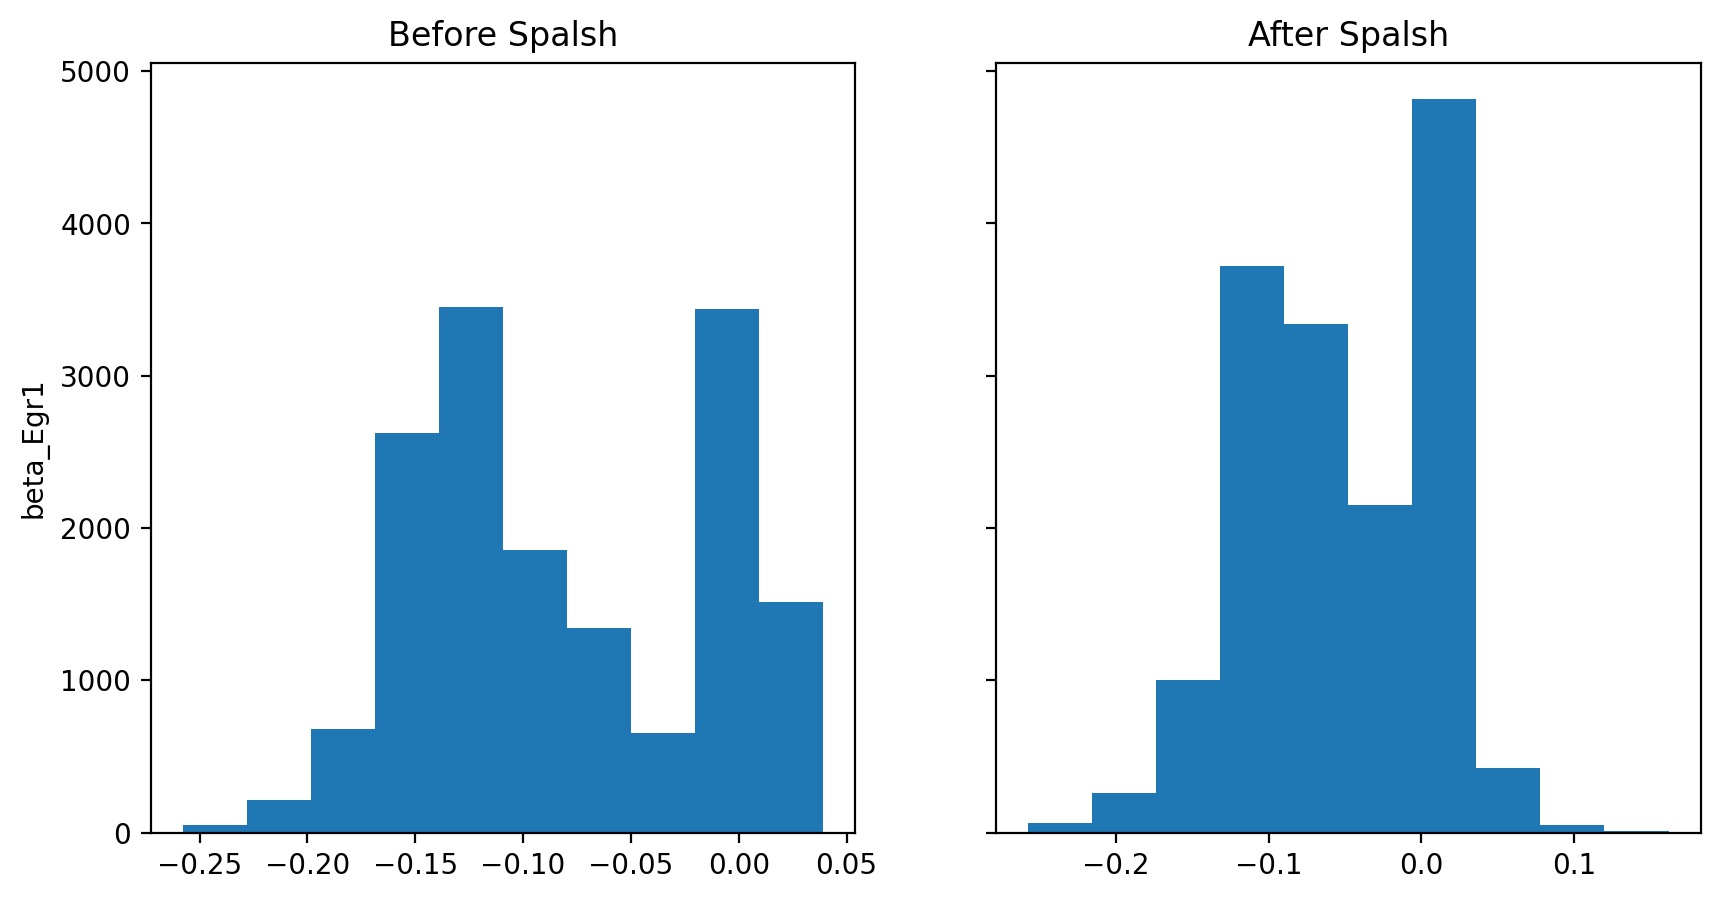

In [110]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
beta = 'beta_Egr1'
pythia.beta_dict.data['Pax5'][beta].plot.hist(ax=ax[0])
wbetas[beta].plot.hist(ax=ax[1])
ax[0].set_title('Before Spalsh')
ax[1].set_title('After Spalsh')
ax[0].set_ylabel(f'{beta}')
plt.show()

In [111]:
pythia.adata.to_df(layer='imputed_count')[['Egr1', 'Pax5']].join(pythia.adata.obs.cell_type).groupby('cell_type').mean()

,Egr1,Pax5
cell_type,,
B-cell,0.017184,0.075197
Cd8 T-cell,0.030936,0.020631
Th2,0.035243,0.022309
Resting T-cell,0.031273,0.017702
Tfh,0.030445,0.026672
Treg,0.030713,0.020147
NK,0.027831,0.017231


<Axes: xlabel='Egr1', ylabel='Pax5'>

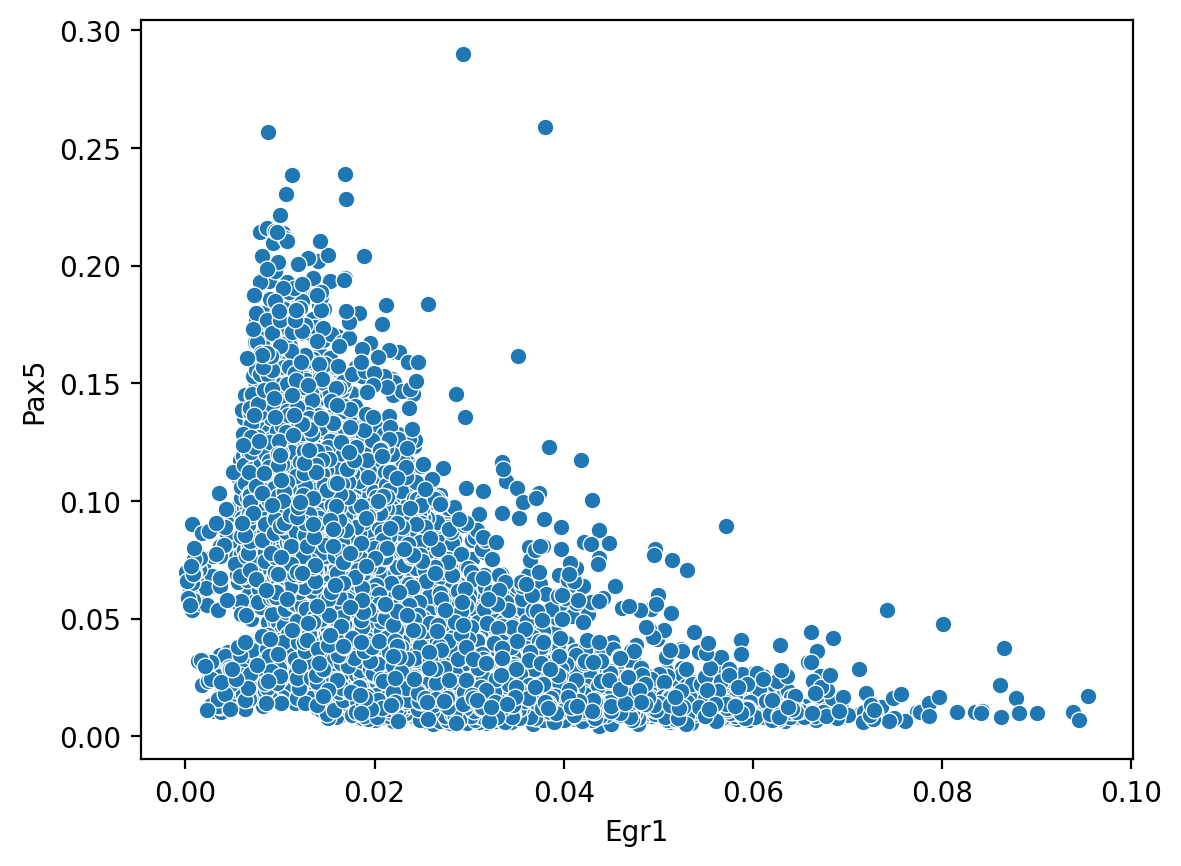

In [112]:
sns.scatterplot(data=adata.to_df(layer='imputed_count'), x='Egr1', y='Pax5')

In [50]:
betadata[beta_cols].mean().sort_values(ascending=False)

beta_Pf4$Cxcr3        2.193610
beta_Ccl20$Ccr6       1.522170
beta_Il10$Il10ra      1.236284
beta_Il10$Il10rb      1.137999
beta_Adm$Calcrl       0.801827
                        ...   
beta_Enho$Gpr19      -1.623874
beta_Il33$Il1rl1     -1.634099
beta_Cx3cl1$Cx3cr1   -2.233999
beta_Il7$Il7r        -2.260836
beta_Cd70$Cd27       -2.999190
Length: 131, dtype: float32

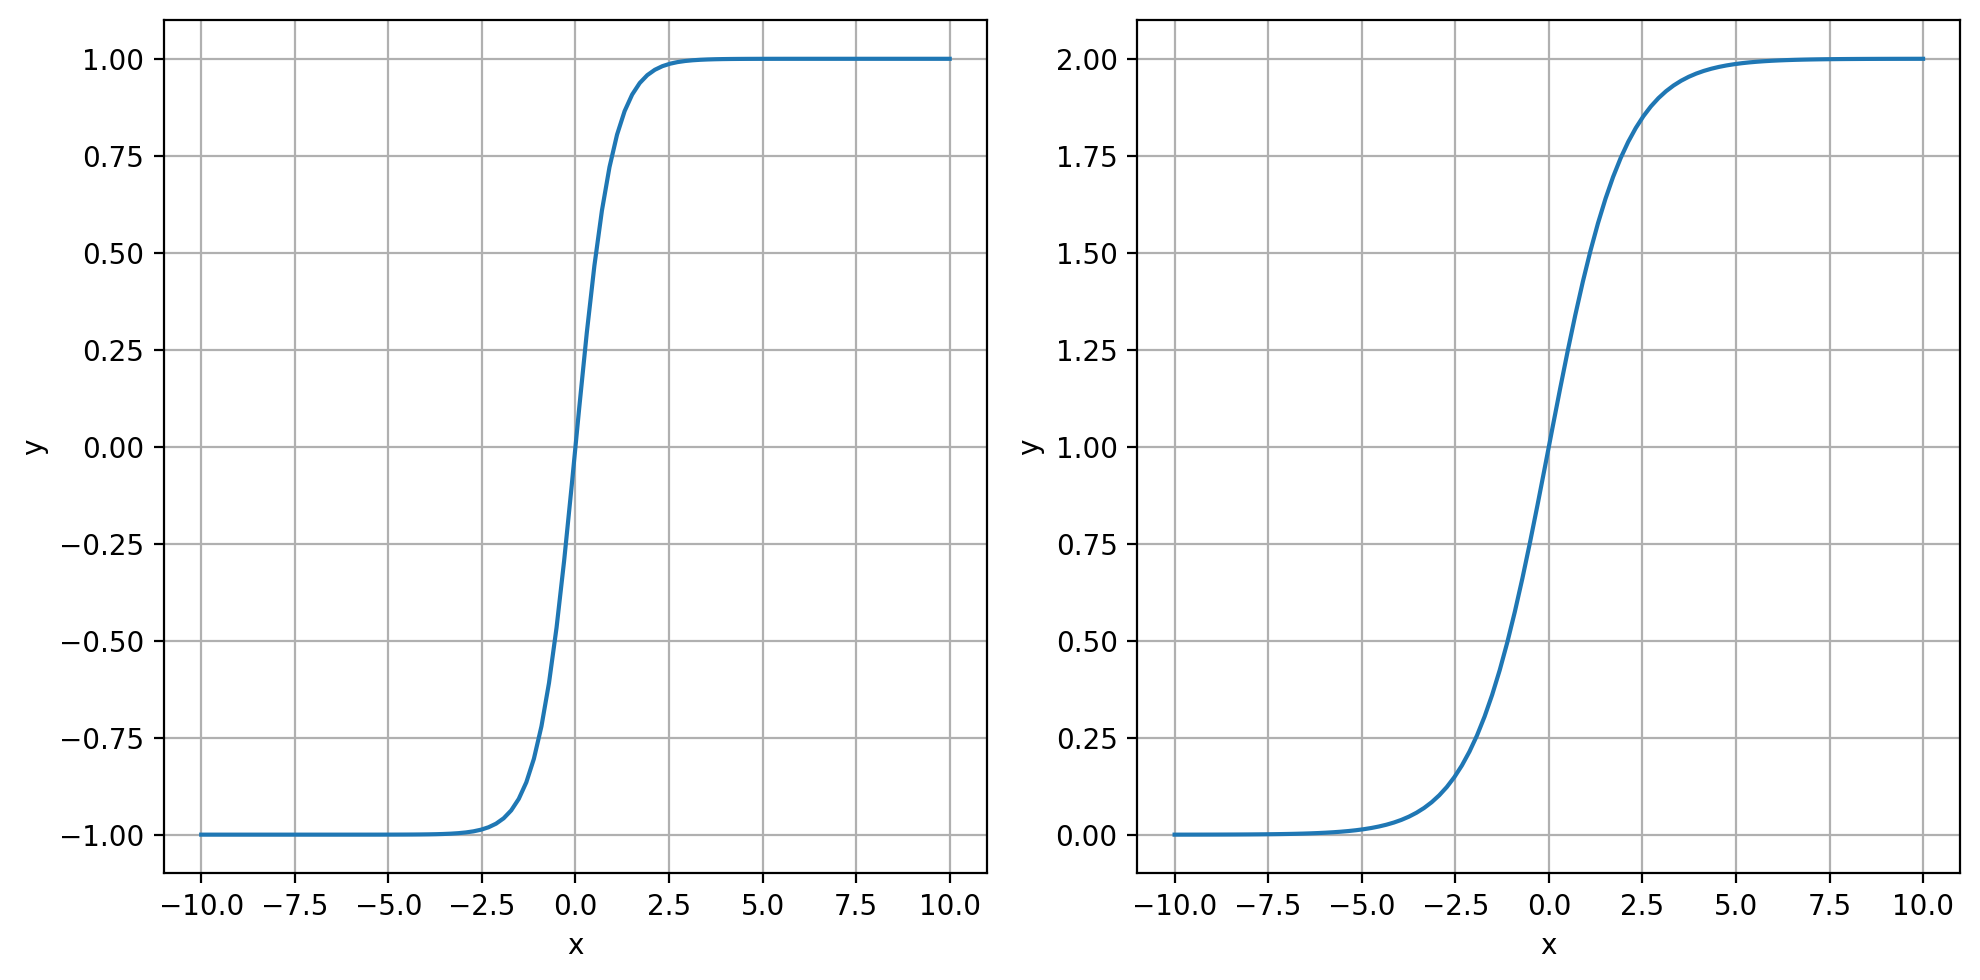

In [82]:
import torch 
import torch.nn.functional as F

x = torch.linspace(-10, 10, 100)
y1 = torch.tanh(x)
y2 = torch.sigmoid(x) * 2

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x.numpy(), y1.numpy())
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122) 
plt.plot(x.numpy(), y2.numpy())
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [ ]:
import duckdb
from fsspec import filesystem
import os

def get_exports_from_zshrc():
    """Load .zshrc file and extract all export statements"""
    try:
        with open(os.path.expanduser('~/.zshrc'), 'r') as f:
            zshrc = f.read()
            
        # Find all export statements
        exports = {}
        for line in zshrc.split('\n'):
            line = line.strip()
            if line.startswith('export'):
                # Remove 'export' and split into key/value
                key_val = line.replace('export', '').strip()
                if '=' in key_val:
                    key, val = key_val.split('=', 1)
                    # Remove quotes if present
                    val = val.strip('"\'')
                    exports[key.strip()] = val

        return exports
    except:
        return {}

# fs = filesystem(
#     'sftp', 
#     host='htc.crc.pitt.edu', 
#     username='kor11', 
#     password=get_exports_from_zshrc()['HTCRC_PASSWORD']
# )

# with fs.open('/ix/djishnu/shared/djishnu_kor11/super_filtered_runs/mLDN3-1_v4/H2-Ab1_betadata.parquet') as f:
#     df_ssh = pd.read_parquet(f)